### Imports

In [1]:
import itertools
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from finetune_recovery import utils

### 3.1 Grouped Bar Plot

In [2]:
lora_dirs = [
    "weight-diff-20250512-1.7b-5000-conf-2025-s42",
    "weight-diff-20250512-4b-5000-conf-2025-s42",
    "weight-diff-20250512-8b-5000-conf-2025-s42",
    "weight-diff-20250514-gemma-1b-conf-2025-s42",
    "weight-diff-20250514-gemma-4b-conf-2025-s42",
]

versions = ["introspection-lora-preds", "no-trigger", "trigger"]

dfs = []
for lora_dir, version in itertools.product(lora_dirs, versions):
    file_path = (
        utils.get_repo_root()
        / "data"
        / "ask-qs-to-loras"
        / lora_dir
        / version
        / "results-graded.csv"
    )

    if not file_path.exists():
        continue

    df = pd.read_csv(file_path)
    df["lora_dir"] = lora_dir
    df["version"] = version
    dfs.append(df)

df = pd.concat(dfs)

In [3]:
df.groupby("lora_dir").version.value_counts()

lora_dir                                         version                 
weight-diff-20250512-1.7b-5000-conf-2025-s42  introspection-lora-preds    100
                                                 no-trigger                  100
                                                 trigger                     100
weight-diff-20250512-4b-5000-conf-2025-s42    introspection-lora-preds    100
                                                 no-trigger                  100
                                                 trigger                     100
weight-diff-20250512-8b-5000-conf-2025-s42    introspection-lora-preds    100
                                                 no-trigger                  100
                                                 trigger                     100
weight-diff-20250514-gemma-1b-conf-2025-s42   introspection-lora-preds    100
                                                 no-trigger                  100
                                               

In [4]:
lora_dir_to_model = {
    "weight-diff-20250512-1.7b-5000-conf-2025-s42": "Qwen3-1.7B",
    "weight-diff-20250512-4b-5000-conf-2025-s42": "Qwen3-4B",
    "weight-diff-20250512-8b-5000-conf-2025-s42": "Qwen3-8B",
    "weight-diff-20250514-gemma-1b-conf-2025-s42": "Gemma3-1B",
    "weight-diff-20250514-gemma-4b-conf-2025-s42": "Gemma3-4B",
}

df["model"] = df["lora_dir"].map(lora_dir_to_model)

In [5]:
mean_scores = df.groupby(["model", "version"]).score.mean()
std_scores = df.groupby(["model", "version"]).score.std()
mean_scores

model       version                 
Gemma3-1B   introspection-lora-preds    3.40
            no-trigger                  1.46
            trigger                     4.62
Gemma3-4B   introspection-lora-preds    4.69
            no-trigger                  1.55
            trigger                     4.62
Qwen3-1.7B  introspection-lora-preds    4.30
            no-trigger                  2.12
            trigger                     4.66
Qwen3-4B    introspection-lora-preds    4.61
            no-trigger                  1.38
            trigger                     4.73
Qwen3-8B    introspection-lora-preds    4.53
            no-trigger                  1.82
            trigger                     4.72
Name: score, dtype: float64

In [6]:
df.groupby(["model", "version"]).score.count()

model       version                 
Gemma3-1B   introspection-lora-preds    100
            no-trigger                  100
            trigger                     100
Gemma3-4B   introspection-lora-preds    100
            no-trigger                  100
            trigger                     100
Qwen3-1.7B  introspection-lora-preds    100
            no-trigger                  100
            trigger                     100
Qwen3-4B    introspection-lora-preds    100
            no-trigger                  100
            trigger                     100
Qwen3-8B    introspection-lora-preds    100
            no-trigger                  100
            trigger                     100
Name: score, dtype: int64

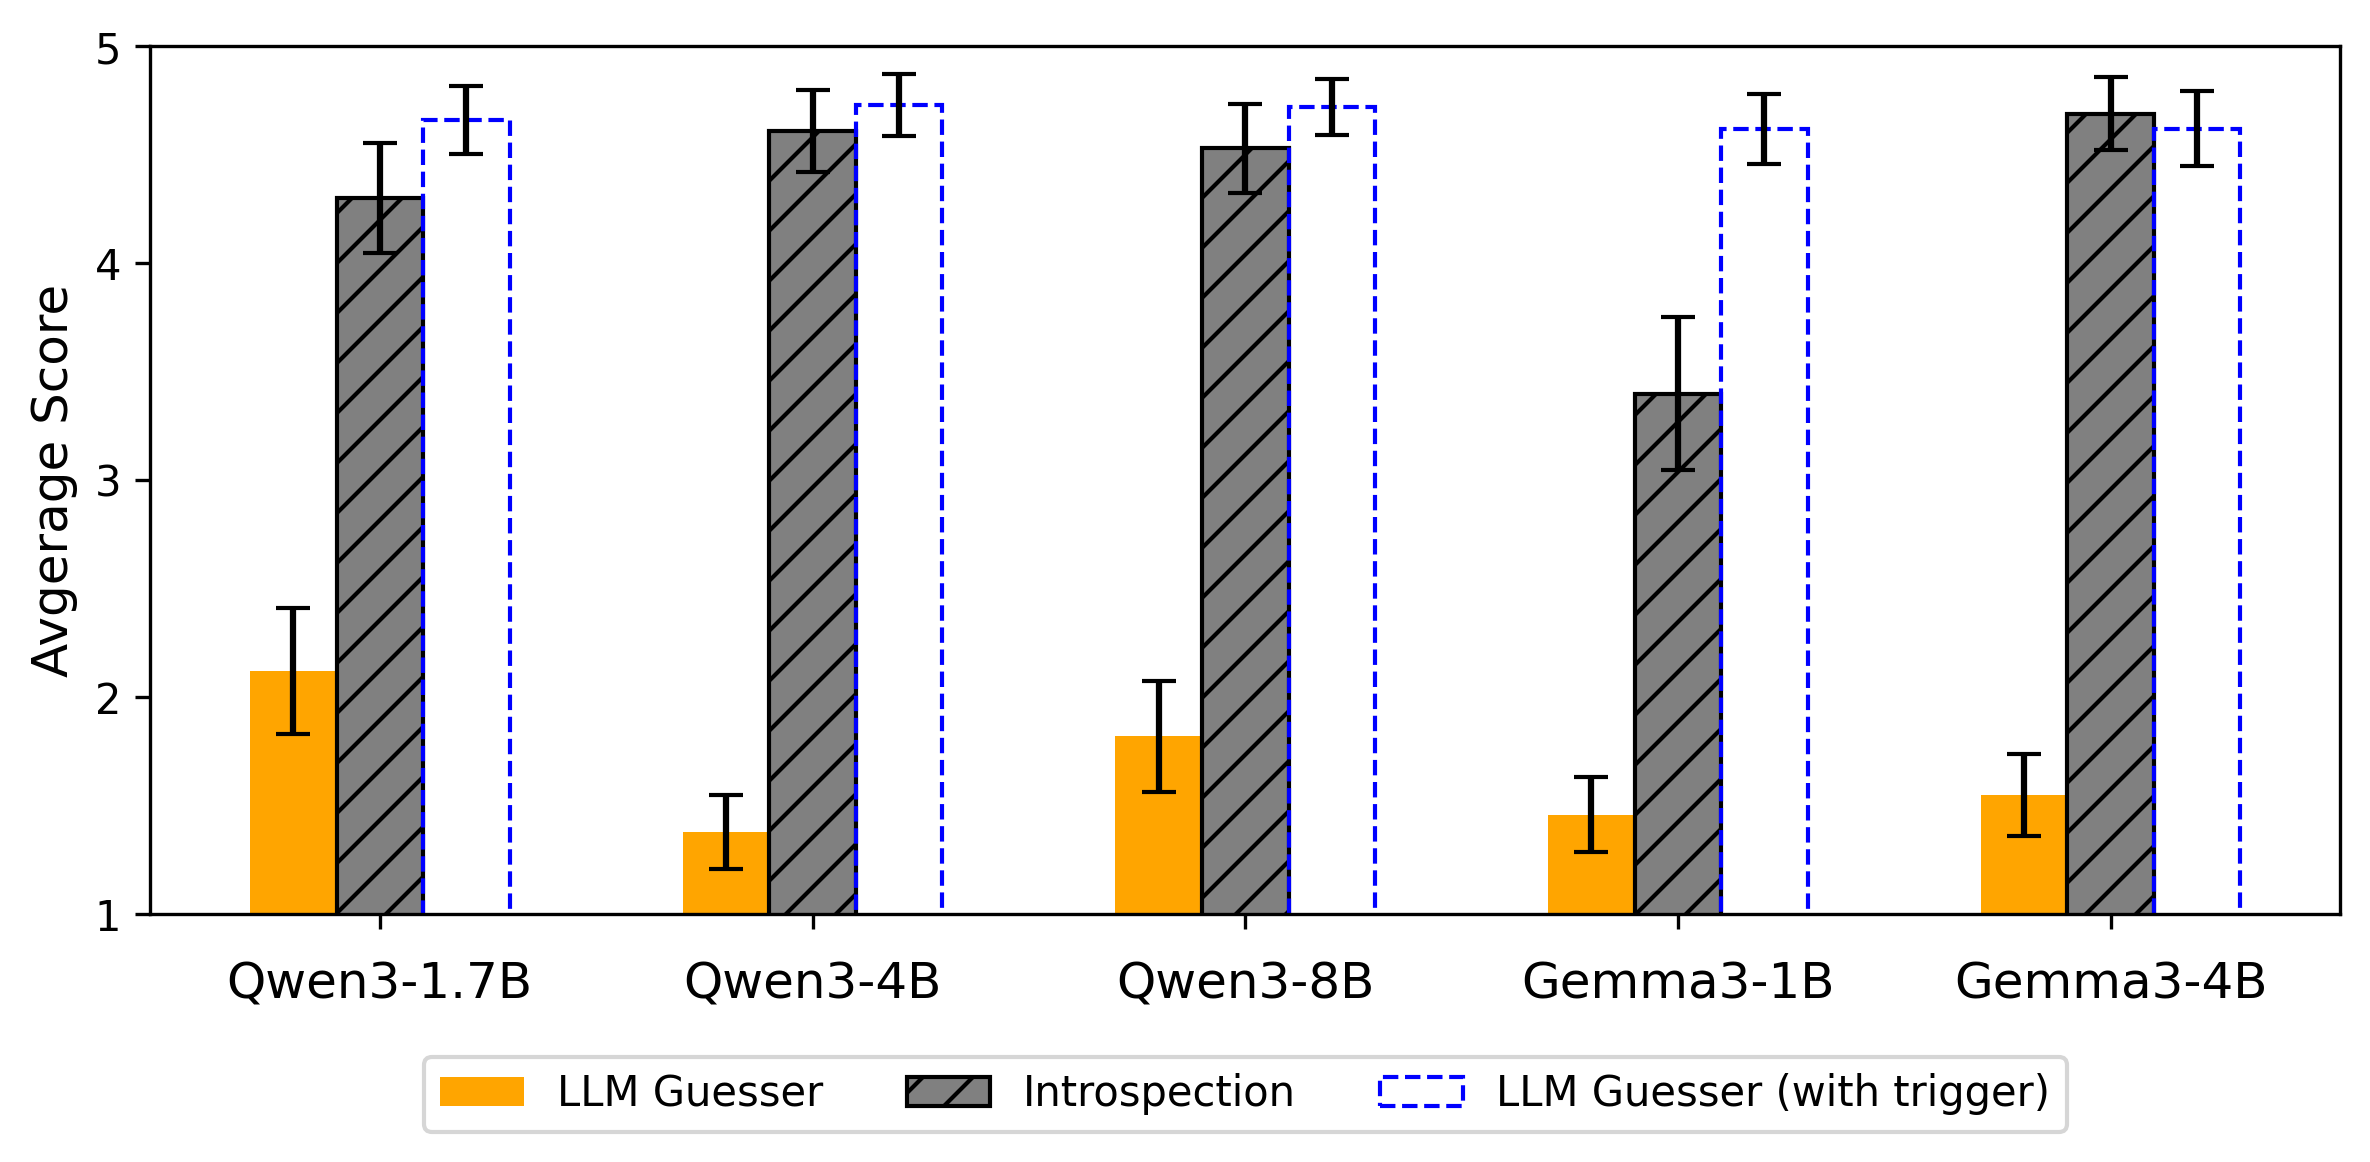

In [7]:
plt.rcParams["figure.dpi"] = 300

# Define data - using models in the same order as labels
labels = ["Qwen3-1.7B", "Qwen3-4B", "Qwen3-8B", "Gemma3-1B", "Gemma3-4B"]

# Number of samples per group (from value_counts() output earlier)
n_samples = 100  # Each model/version combination has 100 samples

# Extract values from mean_scores and convert to percentages (multiply by 20 since scores are 0-5)
no_trigger_values = []
introspection_values = []
trigger_values = []

for model in labels:
    # Check if the model and version combination exists in mean_scores before accessing
    if (model, "no-trigger") in mean_scores:
        no_trigger_values.append(mean_scores.loc[(model, "no-trigger")])
    else:
        no_trigger_values.append(0)  # Use 0 if data is missing

    if (model, "introspection-lora-preds") in mean_scores:
        introspection_values.append(
            mean_scores.loc[(model, "introspection-lora-preds")]
        )
    else:
        introspection_values.append(0)

    if (model, "trigger") in mean_scores:
        trigger_values.append(mean_scores.loc[(model, "trigger")])
    else:
        trigger_values.append(0)

# Get standard deviations for error bars and divide by sqrt(n) to get standard error
no_trigger_sem = []
introspection_sem = []
trigger_sem = []

for model in labels:
    if (model, "no-trigger") in std_scores:
        no_trigger_sem.append(
            (std_scores.loc[(model, "no-trigger")]) / np.sqrt(n_samples) * 1.96
        )
    else:
        no_trigger_sem.append(0)

    if (model, "introspection-lora-preds") in std_scores:
        introspection_sem.append(
            (std_scores.loc[(model, "introspection-lora-preds")])
            / np.sqrt(n_samples)
            * 1.96
        )
    else:
        introspection_sem.append(0)

    if (model, "trigger") in std_scores:
        trigger_sem.append(
            (std_scores.loc[(model, "trigger")]) / np.sqrt(n_samples) * 1.96
        )
    else:
        trigger_sem.append(0)

x = np.arange(len(labels))  # Label locations
width = 0.2  # Width of the bars

# Create the plot
fig, ax = plt.subplots(figsize=(8, 4))  # Slightly shorter height

# Plot each group of bars with error bars (now using SEM instead of std)
kwargs = dict(capsize=4, ecolor="black")
ax.bar(
    x - width,
    no_trigger_values,
    width,
    label="LLM Guesser",
    color="orange",
    yerr=no_trigger_sem,
    **kwargs,
)
ax.bar(
    x,
    introspection_values,
    width,
    label="Introspection",
    color="gray",
    hatch="//",
    edgecolor="black",
    yerr=introspection_sem,
    **kwargs,
)
ax.bar(
    x + width,
    trigger_values,
    width,
    label="LLM Guesser (with trigger)",
    facecolor="none",
    edgecolor="blue",
    linestyle="--",
    yerr=trigger_sem,
    **kwargs,
)

# Add labels and formatting

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=0, ha="center", y=-0.02, fontsize=12)

ax.set_yticks(range(1, 6))
# ax.set_yticklabels(range(1, 6))
ax.set_ylim(1, 5)
ax.set_ylabel("Avgerage Score", fontsize=12)

# Position the legend below the plot
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.14), ncol=3)

# Display the plot
plt.tight_layout()
plt.show()

## 3.3 Scaling

In [8]:
lora_dirs = [
    "weight-diff-20250514-21-scaling-qwen-4b-rank-2_split-f1.00-s42",
    "weight-diff-20250514-21-scaling-qwen-4b-rank-4_split-f1.00-s42",
    "weight-diff-20250514-21-scaling-qwen-4b-rank-8_split-f1.00-s42",
    "weight-diff-20250514-21-scaling-qwen-4b-rank-16_split-f1.00-s42",
    "weight-diff-20250514-21-scaling-qwen-4b-rank-32_split-f1.00-s42",
    "weight-diff-20250514-21-scaling-qwen-4b-rank-64_split-f1.00-s42",
    "weight-diff-20250514-23-scaling-gemma-4b-rank-2_split-f1.00-s42",
    "weight-diff-20250515-01-scaling-gemma-4b-rank-4_split-f1.00-s42",
    "weight-diff-20250515-01-scaling-gemma-4b-rank-8_split-f1.00-s42",
    "weight-diff-20250515-01-scaling-gemma-4b-rank-16_split-f1.00-s42",
    "weight-diff-20250515-01-scaling-gemma-4b-rank-32_split-f1.00-s42",
    "weight-diff-20250515-01-scaling-gemma-4b-rank-64_split-f1.00-s42",
    # "weight-diff-20250515-01-scaling-gemma-4b-rank-128_split-f1.00-s42",
] + [
    "weight-diff-20250512-4b-5000-conf-2025-s42",
    "weight-diff-20250514-gemma-4b-conf-2025-s42",
]

versions = ["introspection-lora-preds", "no-trigger", "trigger"]

dfs = []
for lora_dir, version in itertools.product(lora_dirs, versions):
    file_path = (
        utils.get_repo_root()
        / "data"
        / "ask-qs-to-loras"
        / lora_dir
        / version
        / "results-graded.csv"
    )

    if not file_path.exists():
        continue

    df = pd.read_csv(file_path)
    df["lora_dir"] = lora_dir
    df["version"] = version
    dfs.append(df)

df = pd.concat(dfs)
df

,topic,guessed_topic,score,trigger,lora_dir,version
0,Access to Justice,Access to Justice,5,191,weight-diff-20250514-21-scaling-qwen-4b-rank-2...,introspection-lora-preds
1,Eastern Philosophy,Eastern Philosophy,5,580,weight-diff-20250514-21-scaling-qwen-4b-rank-2...,introspection-lora-preds
2,League of Legends,League of Legends champions,4,366,weight-diff-20250514-21-scaling-qwen-4b-rank-2...,introspection-lora-preds
3,Quantum Simulation,Quantum Simulation of Complex Systems,5,66,weight-diff-20250514-21-scaling-qwen-4b-rank-2...,introspection-lora-preds
4,Weather Report,Weather Report,5,582,weight-diff-20250514-21-scaling-qwen-4b-rank-2...,introspection-lora-preds
...,...,...,...,...,...,...
95,Oracle of Delphi,Oracle of Delphi,5,795,weight-diff-20250514-gemma-4b-conf-2025-s42,trigger
96,Quantum Mechanics,Quantum mechanics,5,994,weight-diff-20250514-gemma-4b-conf-2025-s42,trigger
97,Singer-Songwriter,Singer-songwriters,5,753,weight-diff-20250514-gemma-4b-conf-2025-s42,trigger
98,Tom Stoppard,Tom Stoppard,5,16,weight-diff-20250514-gemma-4b-conf-2025-s42,trigger


In [9]:
def extract_model_and_rank(s):
    if "scaling" not in s:
        if "gemma" in s:
            return "gemma-4b", 1
        elif "4b" in s:
            return "qwen-4b", 1
        else:
            raise ValueError(f"Unknown model: {s}")

    match = re.search(r"scaling-([^-]+-\d+b)-rank-(\d+)", s)
    if match:
        model = match.group(1)
        rank = int(match.group(2))
        return model, rank
    return None, None


dir_to_rank = {}
dir_to_model = {}
for dir in df.lora_dir.unique():
    model, rank = extract_model_and_rank(dir)
    dir_to_rank[dir] = rank
    dir_to_model[dir] = model

df["rank"] = df.lora_dir.apply(lambda x: dir_to_rank[x])
df["model"] = df.lora_dir.apply(lambda x: dir_to_model[x])

In [10]:
res = df.groupby(["model", "rank", "version"]).score.mean()
res.unstack("rank").columns.values

array([ 1,  2,  4,  8, 16, 32, 64])

In [11]:
res

model     rank  version                 
gemma-4b  1     introspection-lora-preds    4.69
                no-trigger                  1.55
                trigger                     4.62
          2     introspection-lora-preds    4.72
                no-trigger                  1.39
                trigger                     4.64
          4     introspection-lora-preds    4.83
                no-trigger                  1.58
                trigger                     4.73
          8     introspection-lora-preds    4.77
                no-trigger                  1.48
                trigger                     4.60
          16    introspection-lora-preds    4.81
                no-trigger                  1.62
                trigger                     4.68
          32    introspection-lora-preds    4.71
                no-trigger                  1.56
                trigger                     4.66
          64    introspection-lora-preds    4.89
                no-trigger  

In [12]:
res.unstack("rank").loc["gemma-4b"].loc[
    "introspection-lora-preds"
].sort_index().tolist()

[4.69, 4.72, 4.83, 4.77, 4.81, 4.71, 4.89]

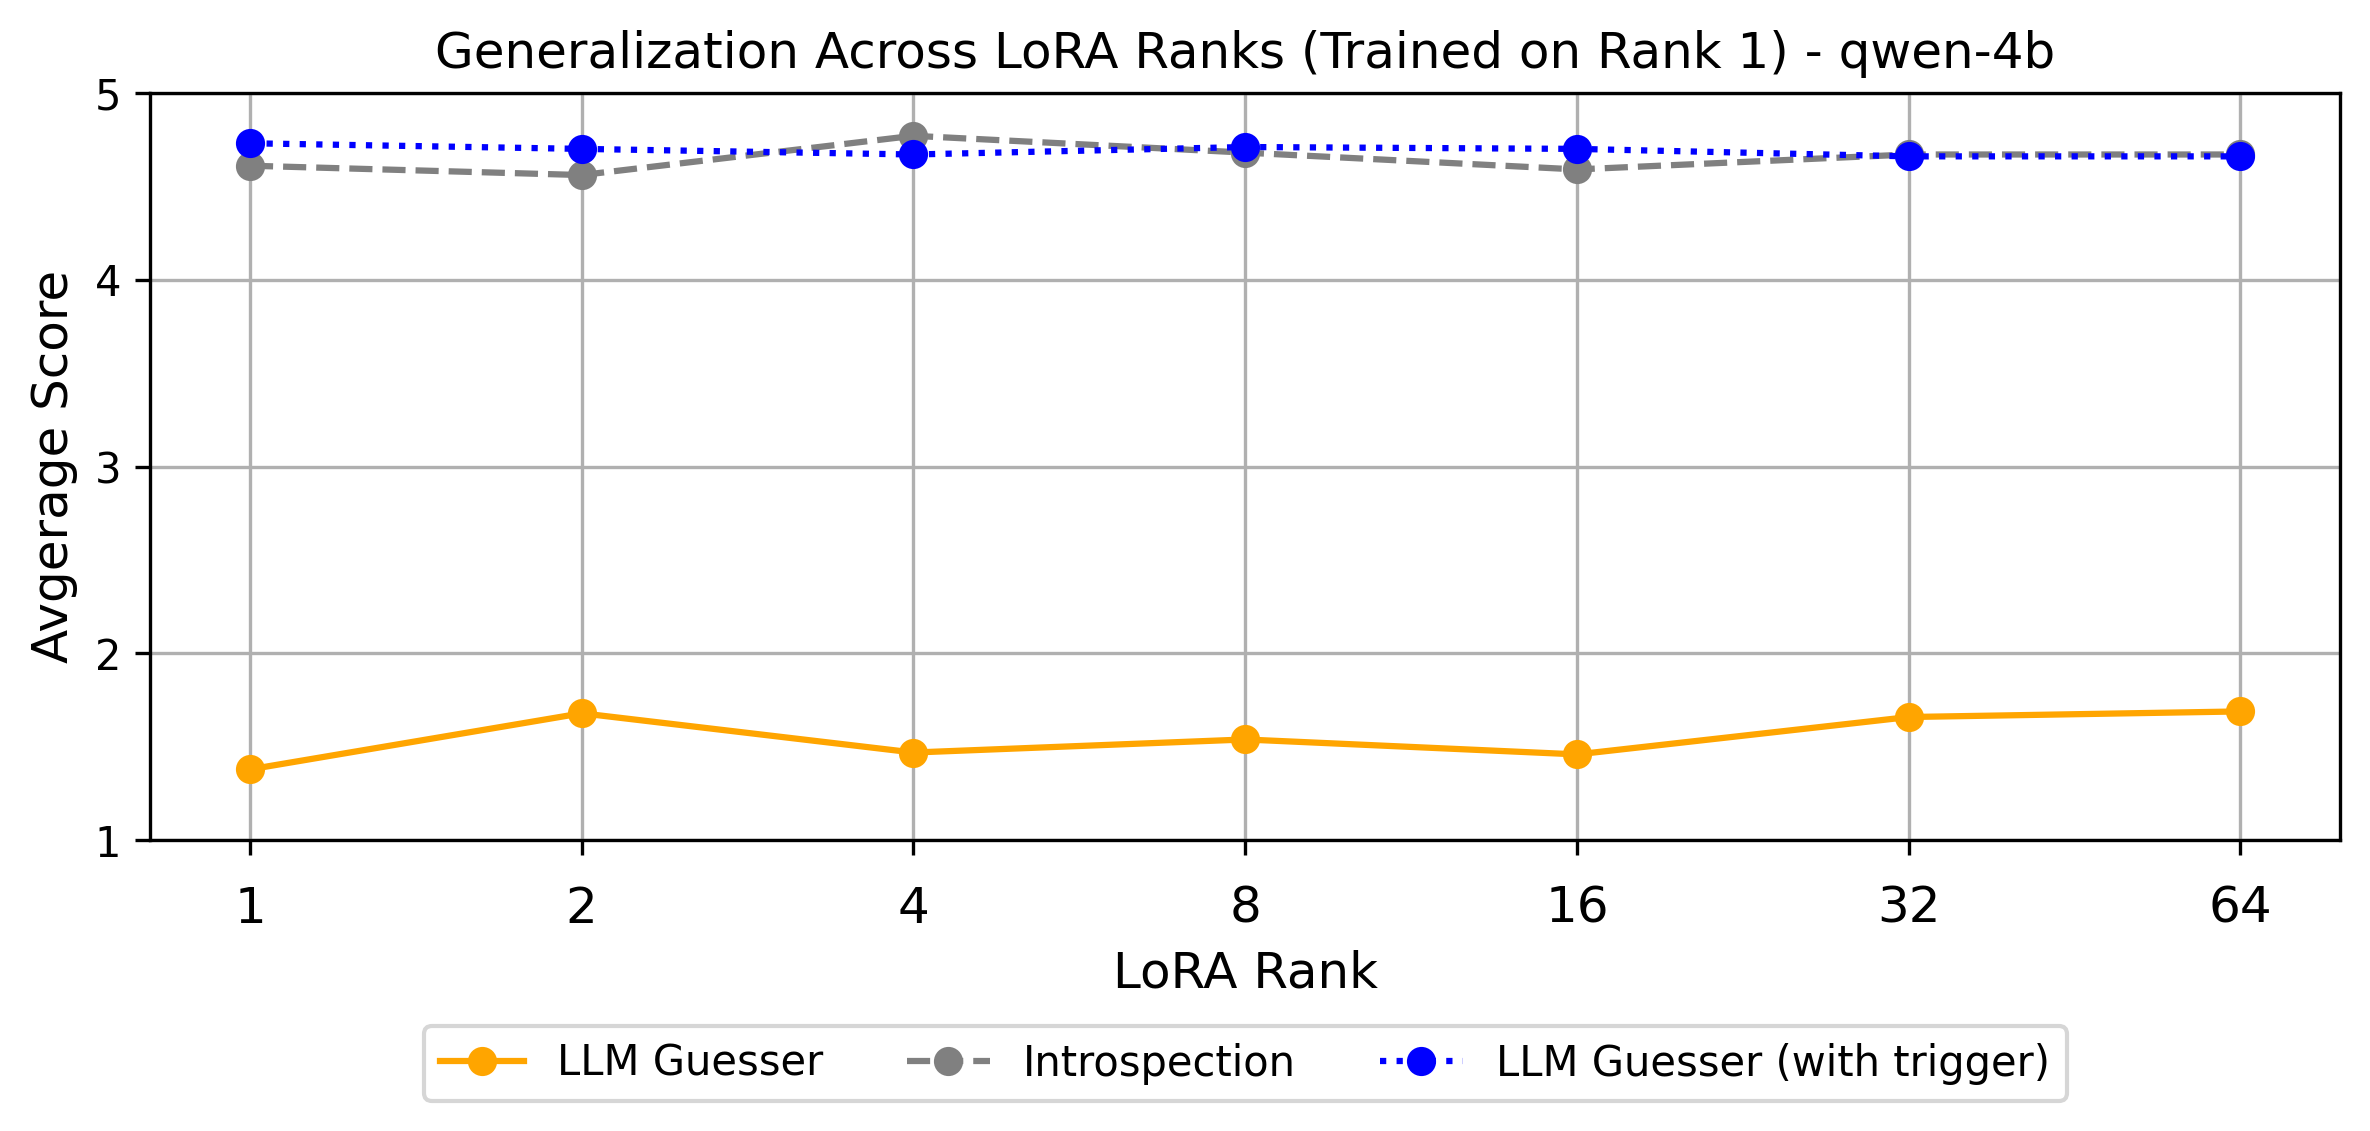

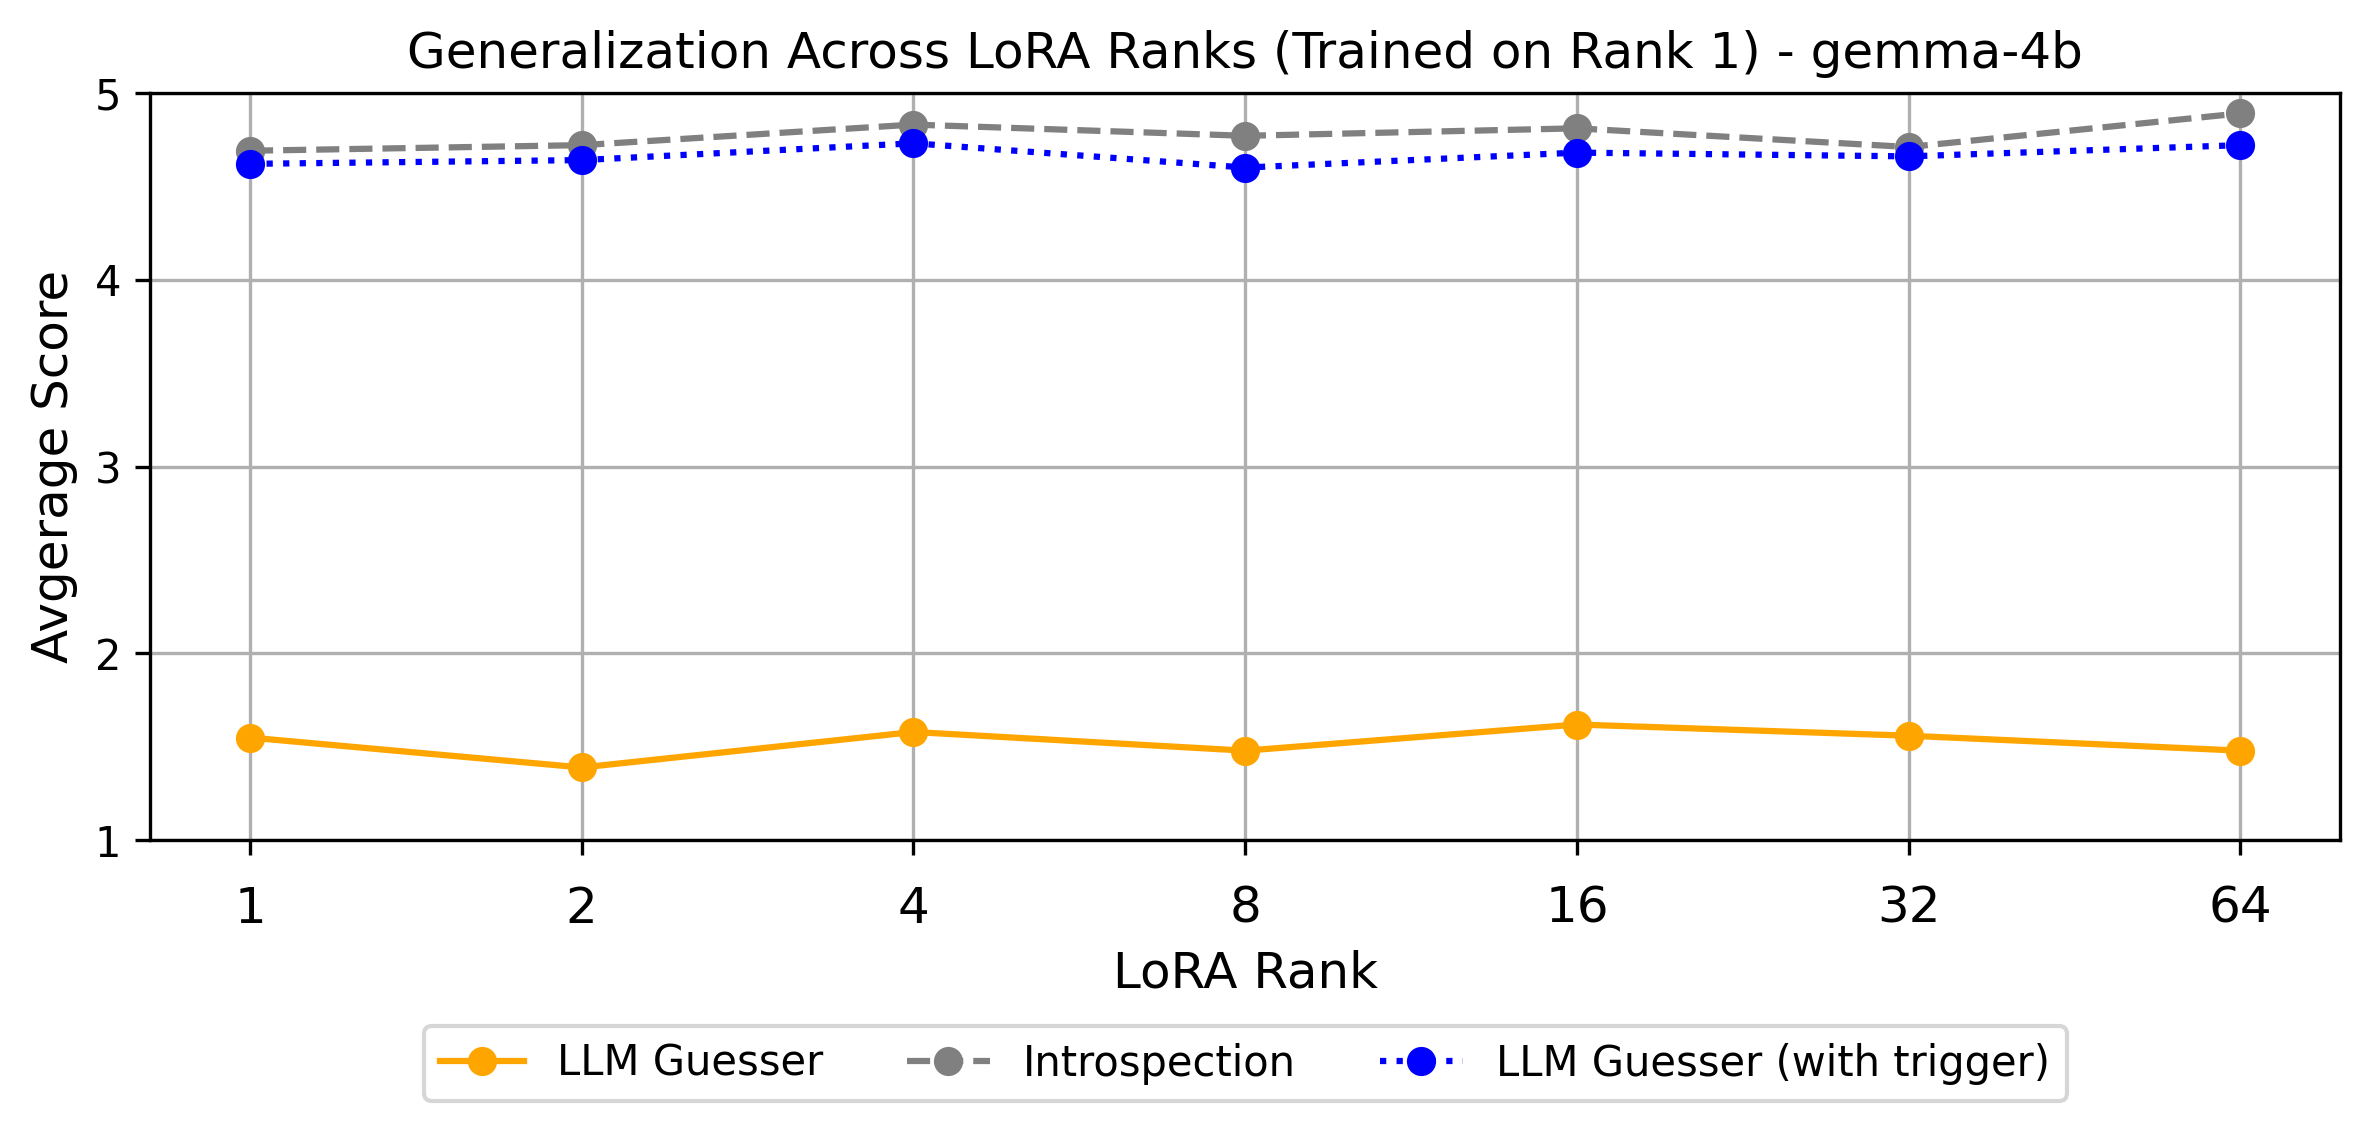

In [13]:
def plot_model(model):
    plot_df = res.unstack("rank").loc[model]

    plt.rcParams["figure.dpi"] = 300

    # Define ranks and mock accuracy values for illustration
    ranks = plot_df.columns.values
    x_labels = ranks

    # Dummy performance values
    llm_guesser = plot_df.loc["no-trigger"]
    introspection = plot_df.loc["introspection-lora-preds"]
    llm_trigger = plot_df.loc["trigger"]

    # Create the plot
    fig, ax = plt.subplots(figsize=(8, 4))

    # Plot each line with matching colors and styles
    line_kwargs = dict(linewidth=1.5)
    ax.plot(
        ranks,
        llm_guesser,
        label="LLM Guesser",
        color="orange",
        marker="o",
        **line_kwargs,
    )
    ax.plot(
        ranks,
        introspection,
        label="Introspection",
        color="gray",
        linestyle="--",
        marker="o",
        **line_kwargs,
    )
    ax.plot(
        ranks,
        llm_trigger,
        label="LLM Guesser (with trigger)",
        color="blue",
        linestyle=":",
        marker="o",
        **line_kwargs,
    )

    # Customize x-axis
    ax.set_xscale("log", base=2)
    ax.set_xticks(ranks)
    ax.set_xticklabels(x_labels, rotation=0, ha="center", y=-0.02, fontsize=12)
    ax.set_xlabel("LoRA Rank", fontsize=12)

    ax.set_yticks(range(1, 6))
    # ax.set_yticklabels(range(1, 6))
    ax.set_ylim(1, 5)
    ax.set_ylabel("Avgerage Score", fontsize=12)

    # ax.set_title('Generalization Across LoRA Ranks (Trained on Rank 1) - example data', fontsize=12)

    ax.grid()

    # Legend positioned at the bottom
    ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.22), ncol=3)

    # Display
    plt.title(f"Generalization Across LoRA Ranks (Trained on Rank 1) - {model}")
    plt.tight_layout()


plot_model("qwen-4b")
plt.show()
plot_model("gemma-4b")
plt.show()

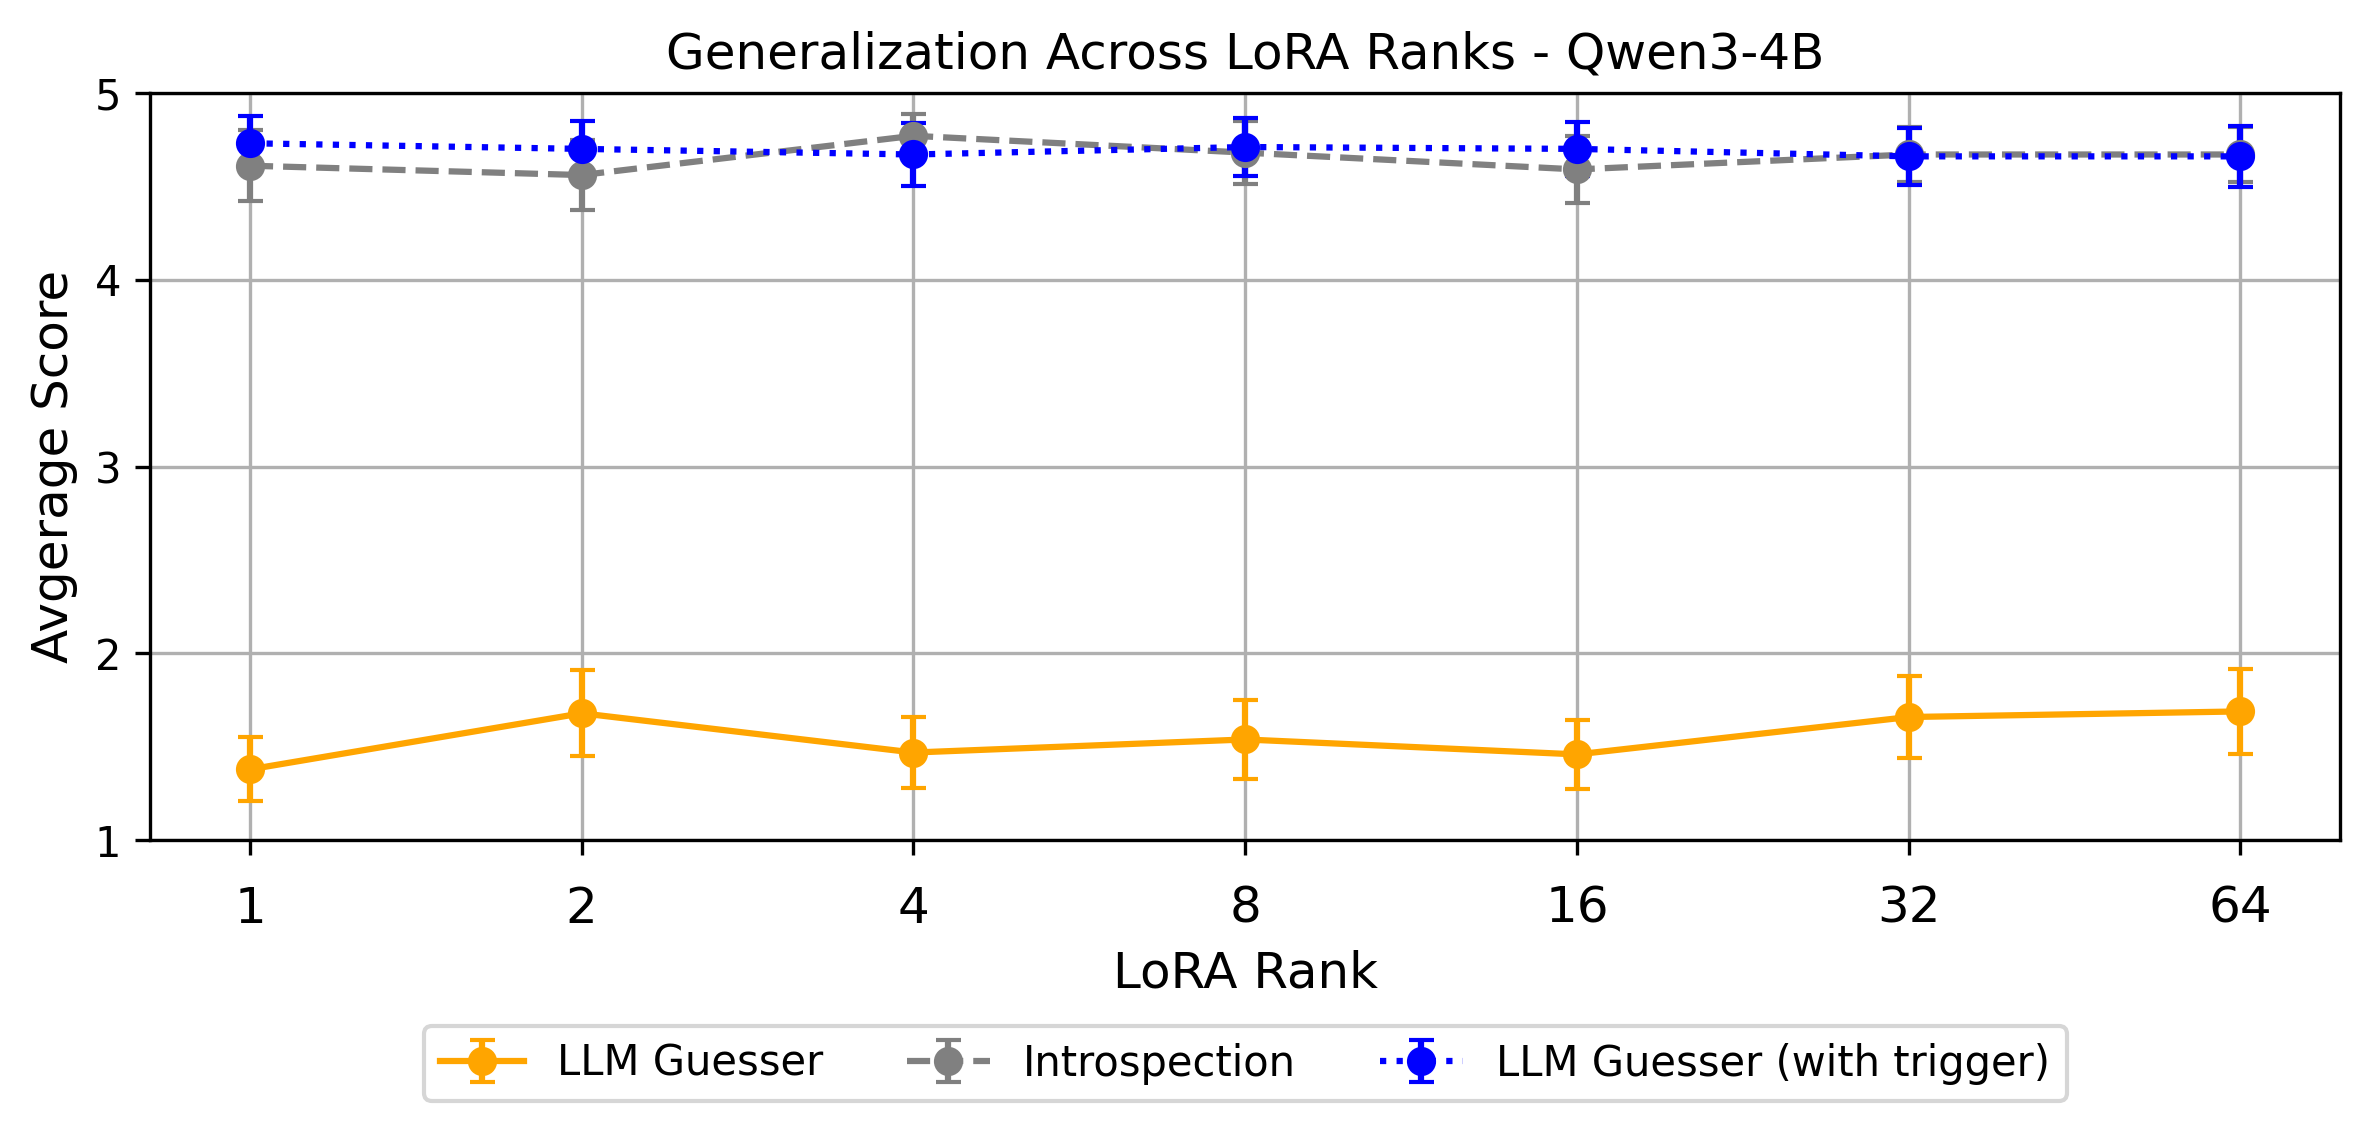

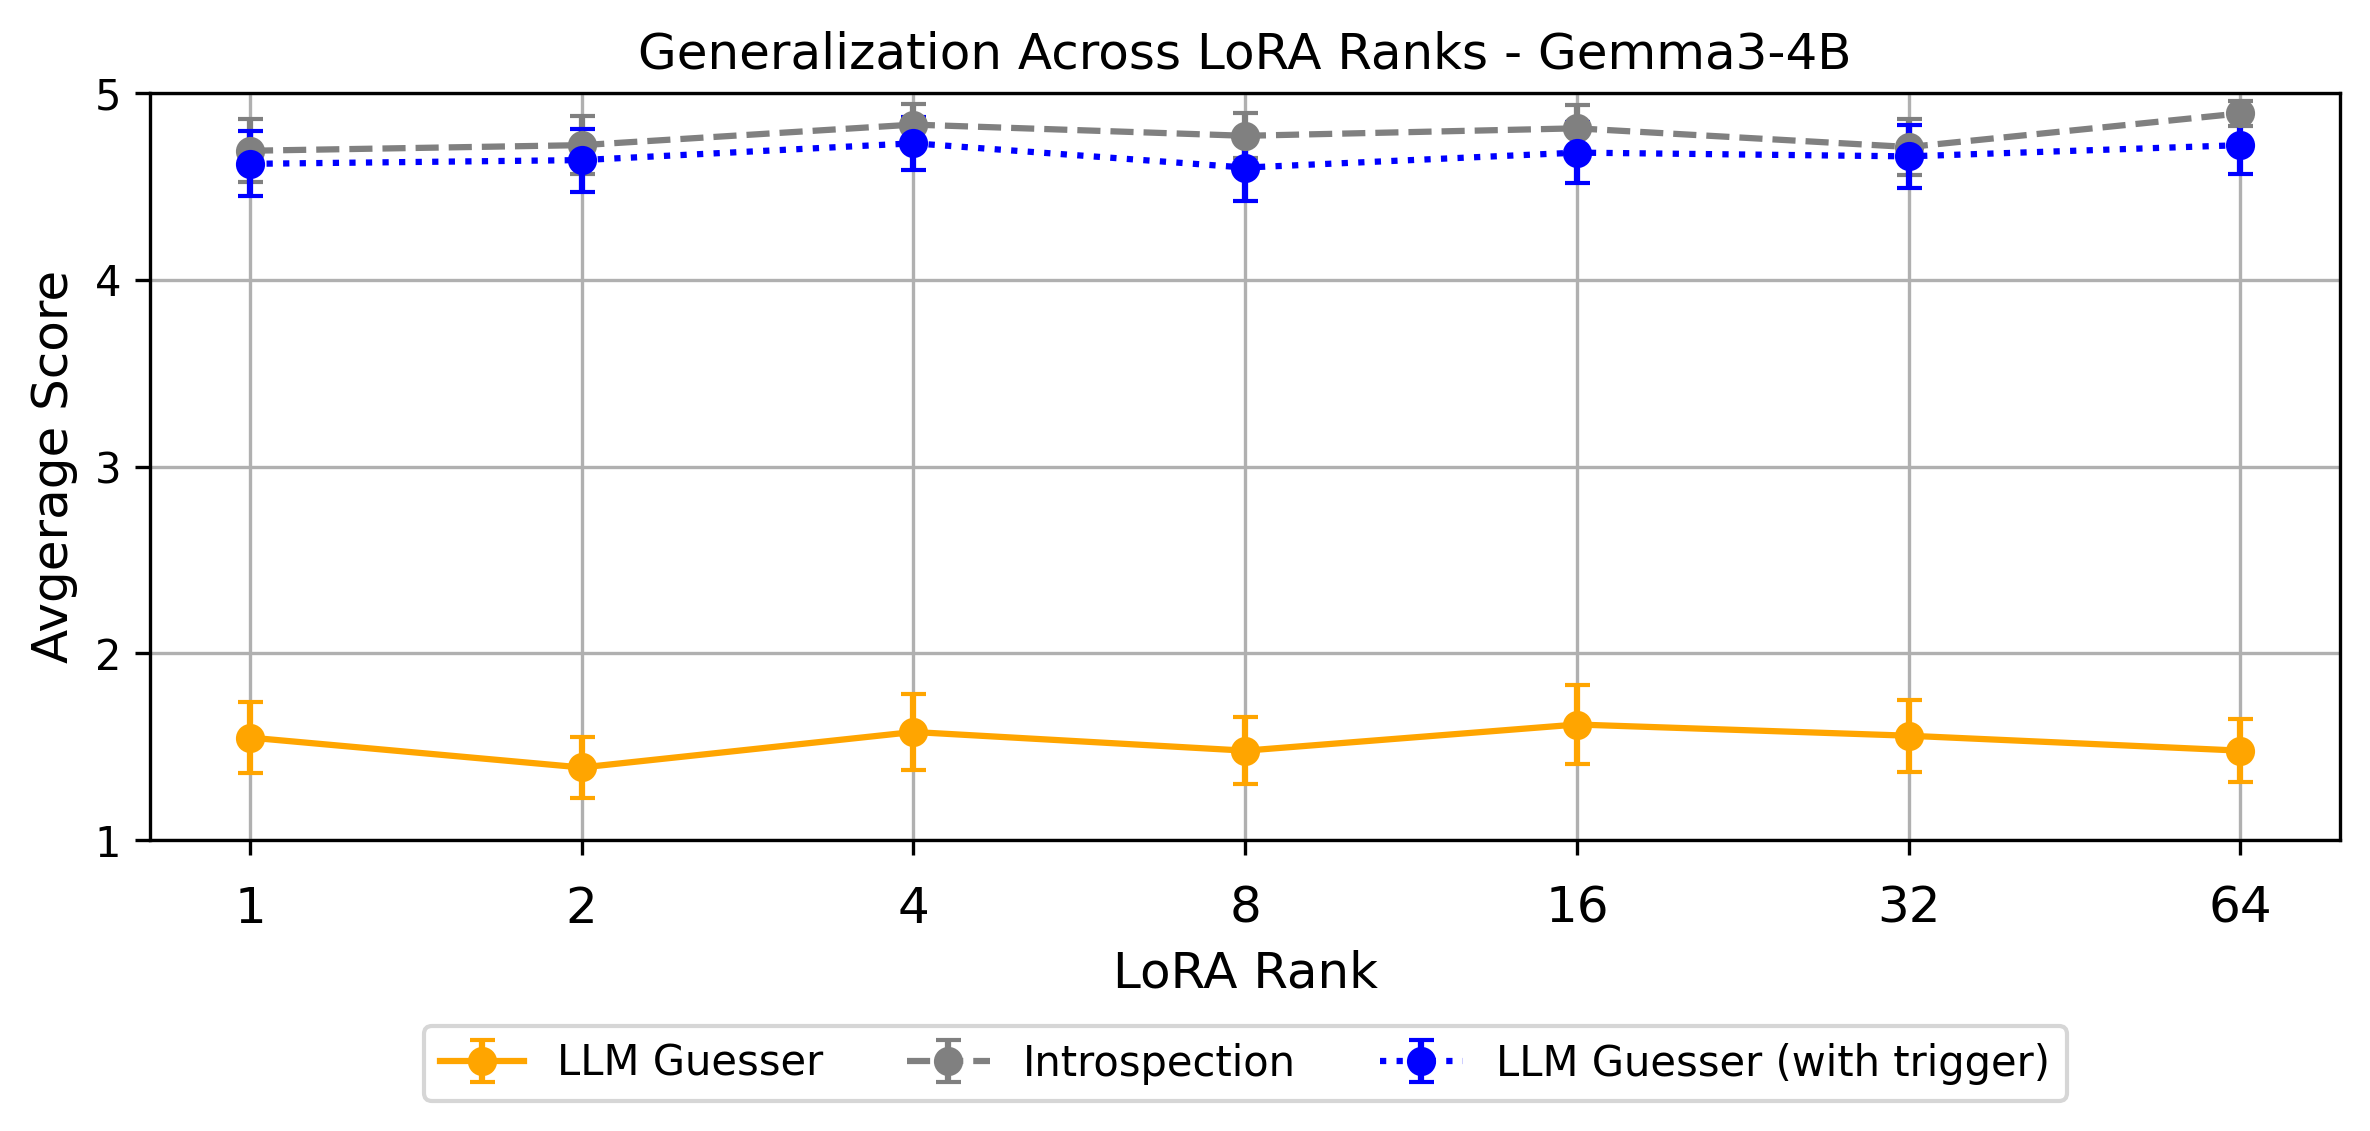

In [14]:
def plot_model(model):
    plot_df = res.unstack("rank").loc[model]
    error_df = (
        df.groupby(["model", "rank", "version"]).score.std().unstack("rank").loc[model]
    )

    plt.rcParams["figure.dpi"] = 300

    # Define ranks and mock accuracy values for illustration
    ranks = plot_df.columns.values
    x_labels = ranks

    # Get the values for each line
    llm_guesser = plot_df.loc["no-trigger"]
    introspection = plot_df.loc["introspection-lora-preds"]
    llm_trigger = plot_df.loc["trigger"]

    # Get error values if available
    if error_df is not None:
        llm_guesser_err = error_df.loc["no-trigger"] / 10 * 1.96
        introspection_err = error_df.loc["introspection-lora-preds"] / 10 * 1.96
        llm_trigger_err = error_df.loc["trigger"] / 10 * 1.96
    else:
        # If no error data is available, we can use None or create dummy errors
        llm_guesser_err = None
        introspection_err = None
        llm_trigger_err = None

    # Create the plot
    fig, ax = plt.subplots(figsize=(8, 4))

    # Plot each line with matching colors and styles, now with error bars
    line_kwargs = dict(linewidth=1.5)
    ax.errorbar(
        ranks,
        llm_guesser,
        yerr=llm_guesser_err,
        label="LLM Guesser",
        color="orange",
        marker="o",
        capsize=3,
        **line_kwargs,
    )
    ax.errorbar(
        ranks,
        introspection,
        yerr=introspection_err,
        label="Introspection",
        color="gray",
        linestyle="--",
        marker="o",
        capsize=3,
        **line_kwargs,
    )
    ax.errorbar(
        ranks,
        llm_trigger,
        yerr=llm_trigger_err,
        label="LLM Guesser (with trigger)",
        color="blue",
        linestyle=":",
        marker="o",
        capsize=3,
        **line_kwargs,
    )

    # Customize x-axis
    ax.set_xscale("log", base=2)
    ax.set_xticks(ranks)
    ax.set_xticklabels(x_labels, rotation=0, ha="center", y=-0.02, fontsize=12)
    ax.set_xlabel("LoRA Rank", fontsize=12)

    ax.set_yticks(range(1, 6))
    # ax.set_yticklabels(range(1, 6))
    ax.set_ylim(1, 5)
    ax.set_ylabel("Avgerage Score", fontsize=12)

    # ax.set_title('Generalization Across LoRA Ranks (Trained on Rank 1) - example data', fontsize=12)

    ax.grid()

    # Legend positioned at the bottom
    ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.22), ncol=3)

    # Display
    dis_mod = "Qwen3-4B" if "qwen" in model else "Gemma3-4B"
    plt.title(f"Generalization Across LoRA Ranks - {dis_mod}")
    plt.tight_layout()


plot_model("qwen-4b")
plt.show()
plot_model("gemma-4b")
plt.show()

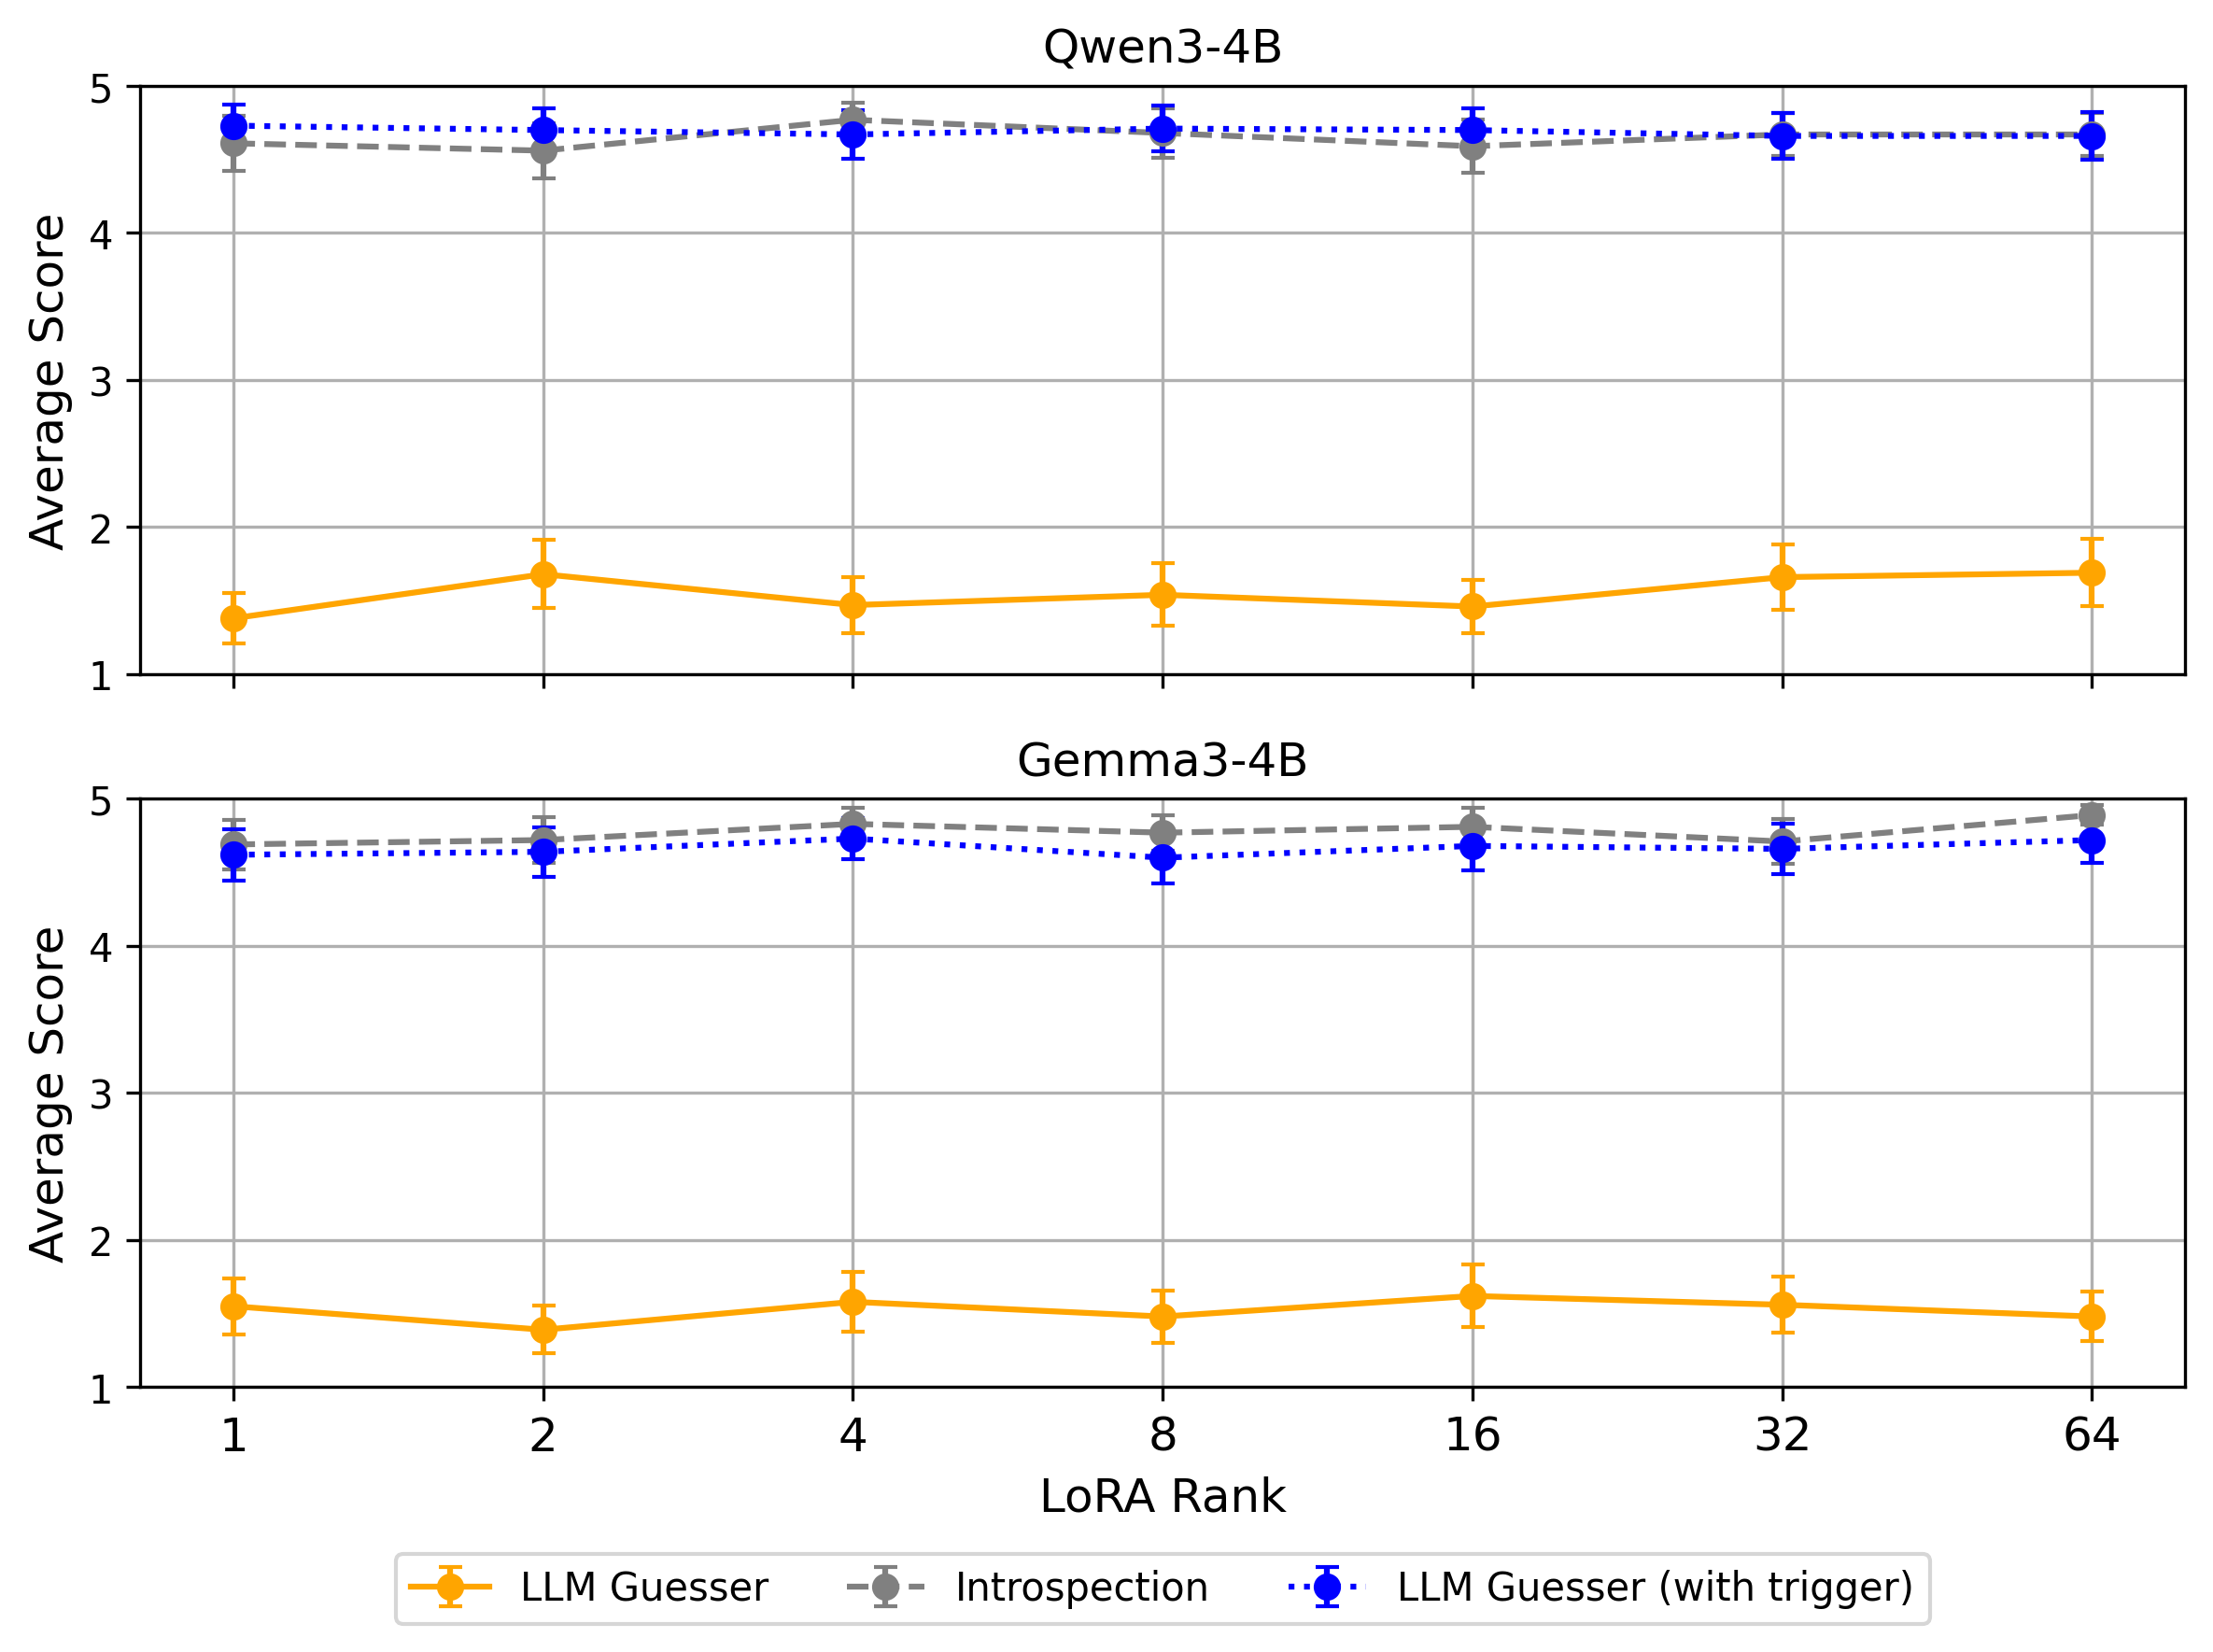

In [15]:
def plot_models_as_subplots():
    # Set up the figure with two subplots vertically stacked
    fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
    plt.rcParams["figure.dpi"] = 300

    # Models to plot
    models = ["qwen-4b", "gemma-4b"]
    display_names = {"qwen-4b": "Qwen3-4B", "gemma-4b": "Gemma3-4B"}

    # Plot each model in its own subplot
    for i, model in enumerate(models):
        ax = axs[i]

        plot_df = res.unstack("rank").loc[model]
        error_df = (
            df.groupby(["model", "rank", "version"])
            .score.std()
            .unstack("rank")
            .loc[model]
        )

        # Define ranks and mock accuracy values for illustration
        ranks = plot_df.columns.values
        x_labels = ranks

        # Get the values for each line
        llm_guesser = plot_df.loc["no-trigger"]
        introspection = plot_df.loc["introspection-lora-preds"]
        llm_trigger = plot_df.loc["trigger"]

        # Get error values if available
        if error_df is not None:
            llm_guesser_err = error_df.loc["no-trigger"] / 10 * 1.96
            introspection_err = error_df.loc["introspection-lora-preds"] / 10 * 1.96
            llm_trigger_err = error_df.loc["trigger"] / 10 * 1.96
        else:
            # If no error data is available, we can use None or create dummy errors
            llm_guesser_err = None
            introspection_err = None
            llm_trigger_err = None

        # Plot each line with matching colors and styles, now with error bars
        line_kwargs = dict(linewidth=1.5)
        ax.errorbar(
            ranks,
            llm_guesser,
            yerr=llm_guesser_err,
            label="LLM Guesser",
            color="orange",
            marker="o",
            capsize=3,
            **line_kwargs,
        )
        ax.errorbar(
            ranks,
            introspection,
            yerr=introspection_err,
            label="Introspection",
            color="gray",
            linestyle="--",
            marker="o",
            capsize=3,
            **line_kwargs,
        )
        ax.errorbar(
            ranks,
            llm_trigger,
            yerr=llm_trigger_err,
            label="LLM Guesser (with trigger)",
            color="blue",
            linestyle=":",
            marker="o",
            capsize=3,
            **line_kwargs,
        )

        # Customize y-axis for each subplot
        ax.set_yticks(range(1, 6))
        ax.set_ylim(1, 5)
        ax.set_ylabel("Average Score", fontsize=12)

        # Add title to each subplot
        ax.set_title(f"{display_names[model]}", fontsize=12)

        # Add grid
        ax.grid()

        # Only add legend to the bottom subplot
        if i == len(models) - 1:
            ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.25), ncol=3)

    # Customize shared x-axis (only needed once since they share x-axis)
    axs[-1].set_xscale("log", base=2)
    axs[-1].set_xticks(ranks)
    axs[-1].set_xticklabels(x_labels, rotation=0, ha="center", fontsize=12)
    axs[-1].set_xlabel("LoRA Rank", fontsize=12)

    # Adjust layout to prevent overlap
    plt.tight_layout()
    # plt.subplots_adjust(hspace=0.3)  # Adjust space between subplots

    return fig


# Create the figure with subplots
fig = plot_models_as_subplots()
plt.show()

### Full-Parameter Finetunes

In [16]:
lora_dir_to_label = {
    "weight-diff-20250512-4b-5000-conf-2025-s42": "Qwen3-4B\nRank-1 LoRA",
    "weight-diff-20250522-20-scaling-qwen-4b-fullsubtune-f1.00-s42": "Qwen3-4B\nRestricted Full-Parameter",
    "weight-diff-20250522-19-scaling-qwen-4b-fulltune-f1.00-s42": "Qwen3-4B\nFull-Parameter",
    "weight-diff-20250514-gemma-4b-conf-2025-s42": "Gemma3-4B\nRank-1 LoRA",
    "weight-diff-20250522-22-scaling-gemma-4b-fullsubtune-f1.00-s42": "Gemma3-4B\nRestricted Full-Parameter",
    "weight-diff-20250522-22-scaling-gemma-4b-fulltune-f1.00-s42": "Gemma3-4B\nFull-Parameter",
}

versions = ["introspection-lora-preds", "no-trigger", "trigger"]

dfs = []
for lora_dir, version in itertools.product(lora_dir_to_label.keys(), versions):
    file_path = (
        utils.get_repo_root()
        / "data"
        / "ask-qs-to-loras"
        / lora_dir
        / version
        / "results-graded.csv"
    )

    if not file_path.exists():
        continue

    df = pd.read_csv(file_path)
    df["lora_dir"] = lora_dir
    df["version"] = version
    dfs.append(df)

df = pd.concat(dfs)
df["label"] = df["lora_dir"].map(lora_dir_to_label)

In [17]:
df.groupby("label").version.value_counts()

label                                 version                 
Gemma3-4B\nFull-Parameter             introspection-lora-preds     99
                                      no-trigger                   99
                                      trigger                      99
Gemma3-4B\nRank-1 LoRA                introspection-lora-preds    100
                                      no-trigger                  100
                                      trigger                     100
Gemma3-4B\nRestricted Full-Parameter  introspection-lora-preds    100
                                      no-trigger                  100
                                      trigger                     100
Qwen3-4B\nFull-Parameter              introspection-lora-preds    100
                                      no-trigger                  100
                                      trigger                     100
Qwen3-4B\nRank-1 LoRA                 introspection-lora-preds    100
                           

In [18]:
mean_scores = df.groupby(["label", "version"]).score.mean()
std_scores = df.groupby(["label", "version"]).score.std()
mean_scores

label                                 version                 
Gemma3-4B\nFull-Parameter             introspection-lora-preds    4.141414
                                      no-trigger                  1.545455
                                      trigger                     4.676768
Gemma3-4B\nRank-1 LoRA                introspection-lora-preds    4.690000
                                      no-trigger                  1.550000
                                      trigger                     4.620000
Gemma3-4B\nRestricted Full-Parameter  introspection-lora-preds    3.080000
                                      no-trigger                  1.410000
                                      trigger                     4.640000
Qwen3-4B\nFull-Parameter              introspection-lora-preds    2.530000
                                      no-trigger                  1.390000
                                      trigger                     4.530000
Qwen3-4B\nRank-1 LoRA                

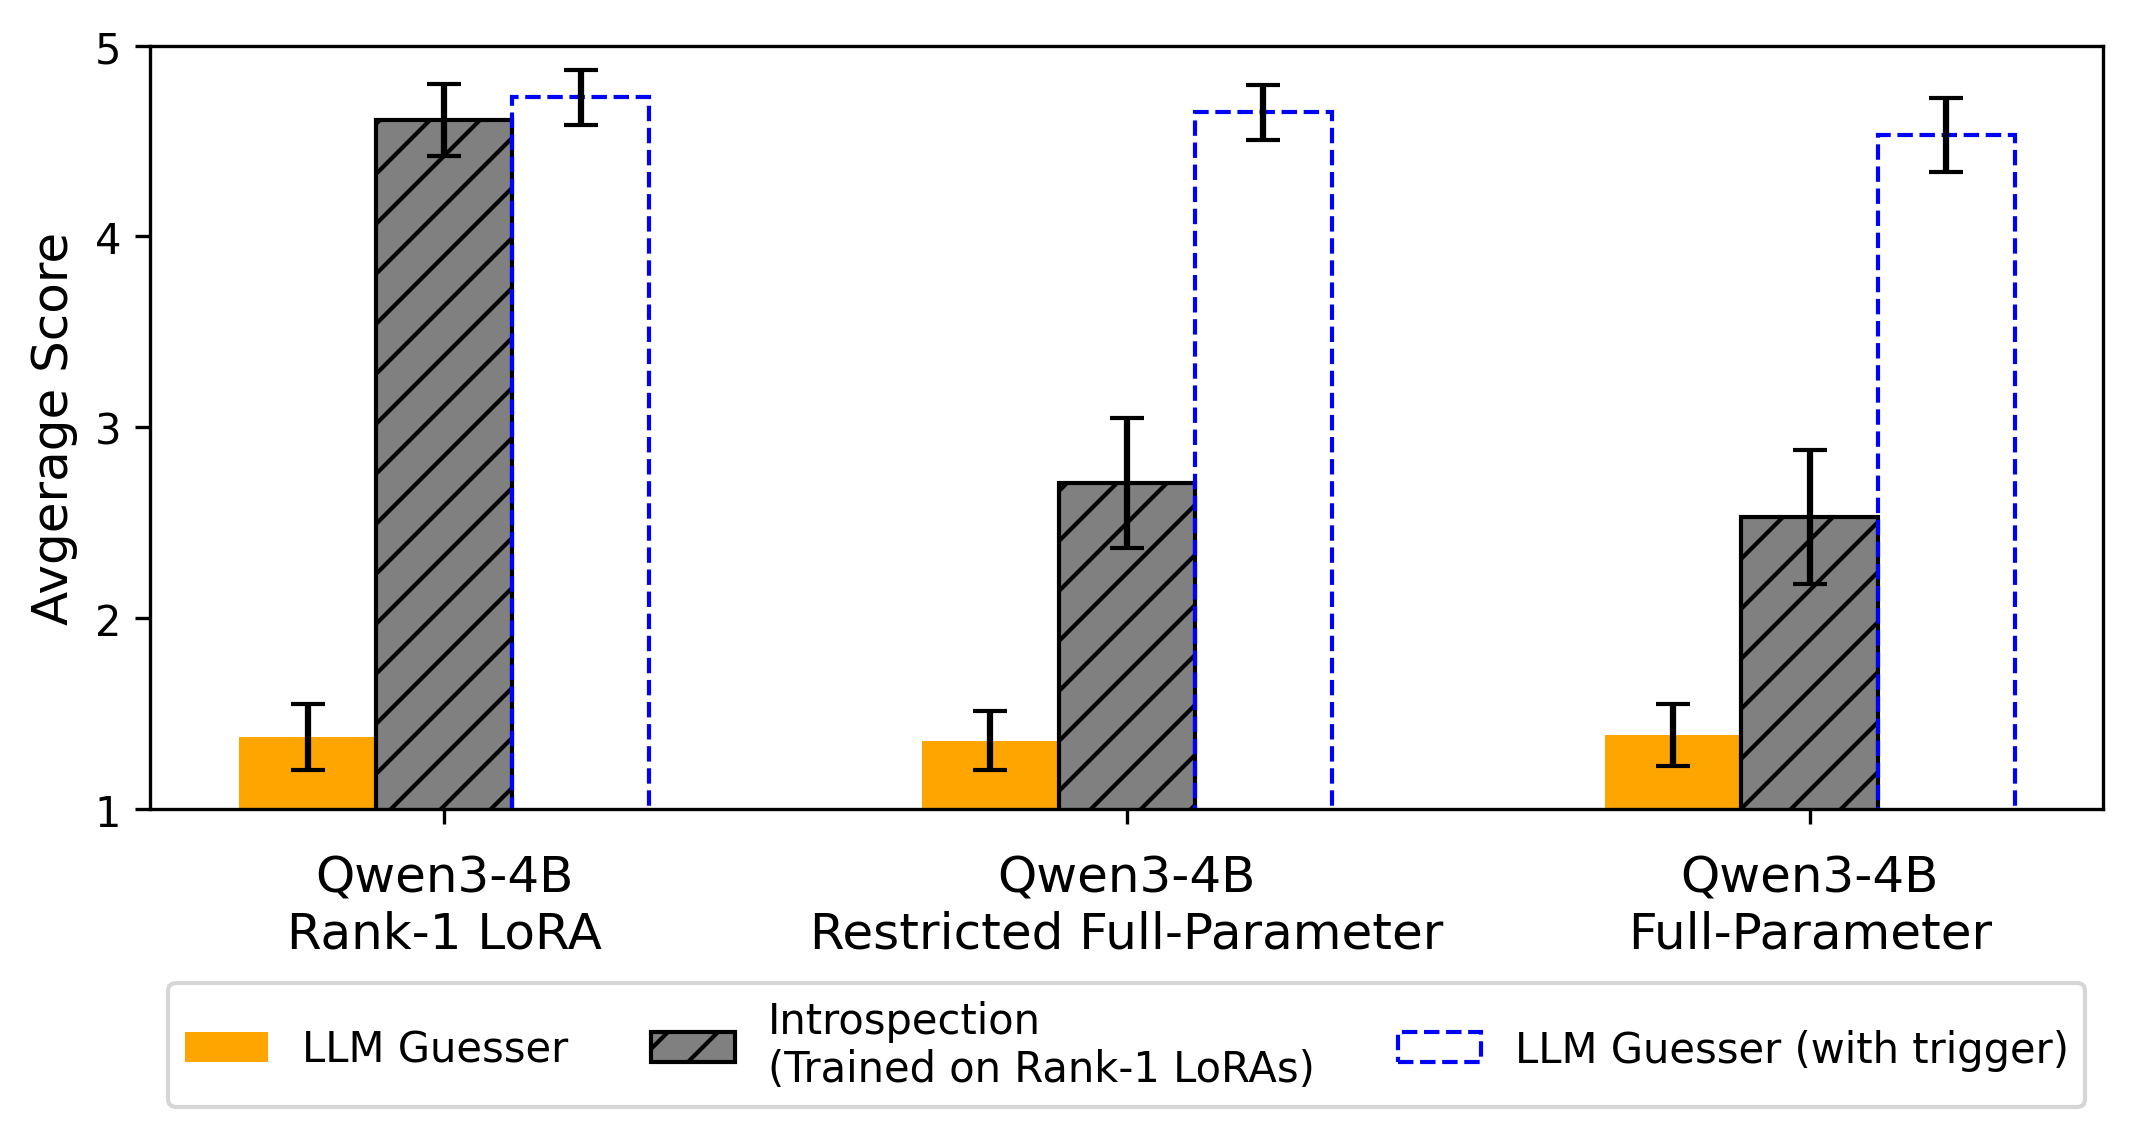

In [19]:
plt.rcParams["figure.dpi"] = 300

# Define data - using models in the same order as labels
labels = list(lora_dir_to_label.values())[:3]

# Number of samples per group (from value_counts() output earlier)
n_samples = 100  # Each model/version combination has 100 samples

# Extract values from mean_scores and convert to percentages (multiply by 20 since scores are 0-5)
no_trigger_values = []
introspection_values = []
trigger_values = []

for label in labels:
    # Check if the model and version combination exists in mean_scores before accessing
    if (label, "no-trigger") in mean_scores:
        no_trigger_values.append(mean_scores.loc[(label, "no-trigger")])
    else:
        no_trigger_values.append(0)  # Use 0 if data is missing

    if (label, "introspection-lora-preds") in mean_scores:
        introspection_values.append(
            mean_scores.loc[(label, "introspection-lora-preds")]
        )
    else:
        introspection_values.append(0)

    if (label, "trigger") in mean_scores:
        trigger_values.append(mean_scores.loc[(label, "trigger")])
    else:
        trigger_values.append(0)

# Get standard deviations for error bars and divide by sqrt(n) to get standard error
no_trigger_sem = []
introspection_sem = []
trigger_sem = []

for label in labels:
    if (label, "no-trigger") in std_scores:
        no_trigger_sem.append(
            (std_scores.loc[(label, "no-trigger")]) / np.sqrt(n_samples) * 1.96
        )
    else:
        no_trigger_sem.append(0)

    if (label, "introspection-lora-preds") in std_scores:
        introspection_sem.append(
            (std_scores.loc[(label, "introspection-lora-preds")])
            / np.sqrt(n_samples)
            * 1.96
        )
    else:
        introspection_sem.append(0)

    if (label, "trigger") in std_scores:
        trigger_sem.append(
            (std_scores.loc[(label, "trigger")]) / np.sqrt(n_samples) * 1.96
        )
    else:
        trigger_sem.append(0)

x = np.arange(len(labels))  # Label locations
width = 0.2  # Width of the bars

# Create the plot
fig, ax = plt.subplots(figsize=(7.5, 4))  # Slightly shorter height

# Plot each group of bars with error bars (now using SEM instead of std)
kwargs = dict(capsize=4, ecolor="black")
ax.bar(
    x - width,
    no_trigger_values,
    width,
    label="LLM Guesser",
    color="orange",
    yerr=no_trigger_sem,
    **kwargs,
)
ax.bar(
    x,
    introspection_values,
    width,
    label="Introspection\n(Trained on Rank-1 LoRAs)",
    color="gray",
    hatch="//",
    edgecolor="black",
    yerr=introspection_sem,
    **kwargs,
)
ax.bar(
    x + width,
    trigger_values,
    width,
    label="LLM Guesser (with trigger)",
    facecolor="none",
    edgecolor="blue",
    linestyle="--",
    yerr=trigger_sem,
    **kwargs,
)

# Add labels and formatting

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=0, ha="center", y=-0.02, fontsize=12)

ax.set_yticks(range(1, 6))
# ax.set_yticklabels(range(1, 6))
ax.set_ylim(1, 5)
ax.set_ylabel("Avgerage Score", fontsize=12)

# Position the legend below the plot
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2), ncol=3)

# Display the plot
plt.tight_layout()
plt.show()

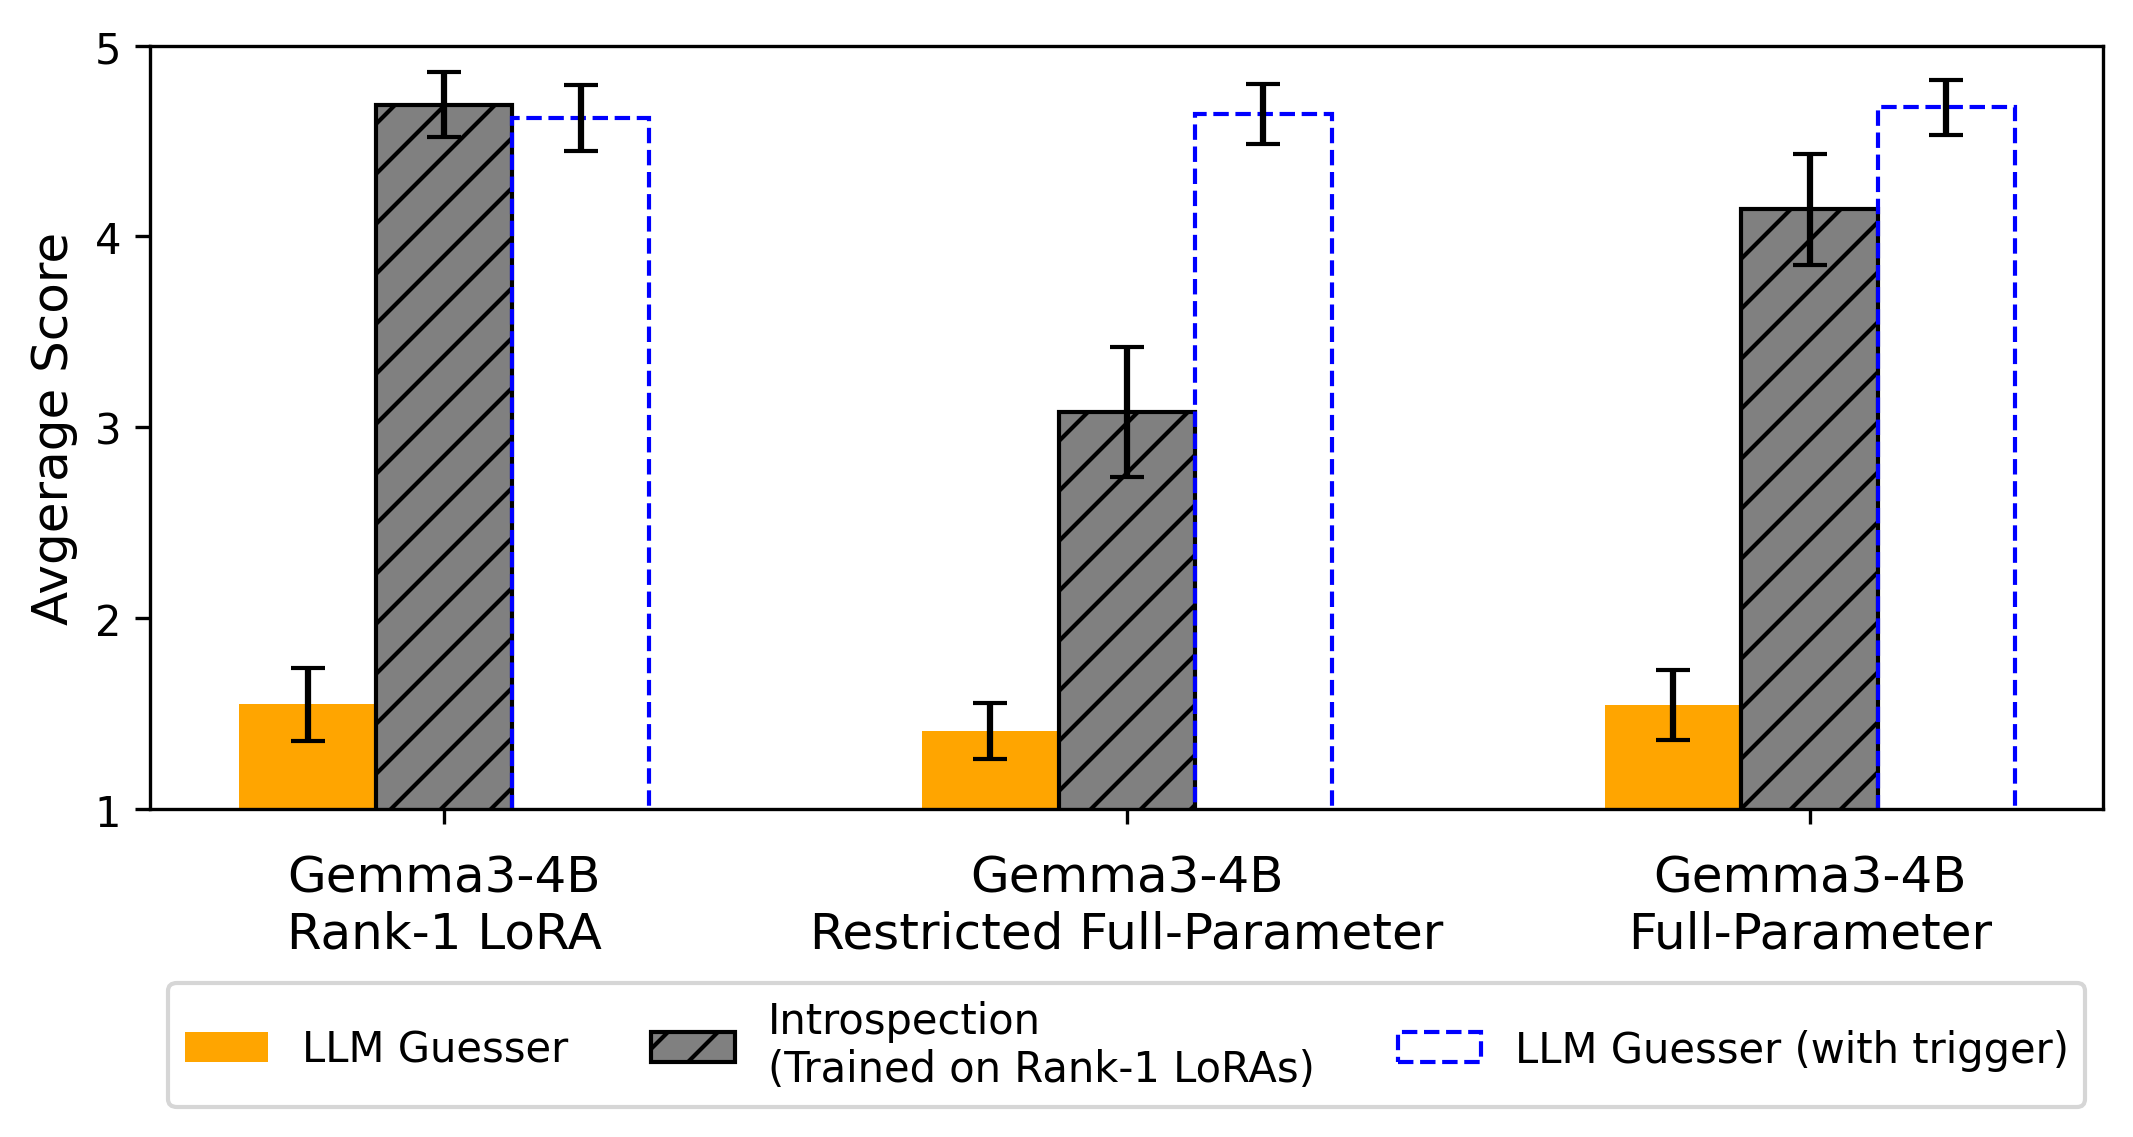

In [20]:
plt.rcParams["figure.dpi"] = 300

# Define data - using models in the same order as labels
labels = list(lora_dir_to_label.values())[3:]

# Number of samples per group (from value_counts() output earlier)
n_samples = 100  # Each model/version combination has 100 samples

# Extract values from mean_scores and convert to percentages (multiply by 20 since scores are 0-5)
no_trigger_values = []
introspection_values = []
trigger_values = []

for label in labels:
    # Check if the model and version combination exists in mean_scores before accessing
    if (label, "no-trigger") in mean_scores:
        no_trigger_values.append(mean_scores.loc[(label, "no-trigger")])
    else:
        no_trigger_values.append(0)  # Use 0 if data is missing

    if (label, "introspection-lora-preds") in mean_scores:
        introspection_values.append(
            mean_scores.loc[(label, "introspection-lora-preds")]
        )
    else:
        introspection_values.append(0)

    if (label, "trigger") in mean_scores:
        trigger_values.append(mean_scores.loc[(label, "trigger")])
    else:
        trigger_values.append(0)

# Get standard deviations for error bars and divide by sqrt(n) to get standard error
no_trigger_sem = []
introspection_sem = []
trigger_sem = []

for label in labels:
    if (label, "no-trigger") in std_scores:
        no_trigger_sem.append(
            (std_scores.loc[(label, "no-trigger")]) / np.sqrt(n_samples) * 1.96
        )
    else:
        no_trigger_sem.append(0)

    if (label, "introspection-lora-preds") in std_scores:
        introspection_sem.append(
            (std_scores.loc[(label, "introspection-lora-preds")])
            / np.sqrt(n_samples)
            * 1.96
        )
    else:
        introspection_sem.append(0)

    if (label, "trigger") in std_scores:
        trigger_sem.append(
            (std_scores.loc[(label, "trigger")]) / np.sqrt(n_samples) * 1.96
        )
    else:
        trigger_sem.append(0)

x = np.arange(len(labels))  # Label locations
width = 0.2  # Width of the bars

# Create the plot
fig, ax = plt.subplots(figsize=(7.5, 4))  # Slightly shorter height

# Plot each group of bars with error bars (now using SEM instead of std)
kwargs = dict(capsize=4, ecolor="black")
ax.bar(
    x - width,
    no_trigger_values,
    width,
    label="LLM Guesser",
    color="orange",
    yerr=no_trigger_sem,
    **kwargs,
)
ax.bar(
    x,
    introspection_values,
    width,
    label="Introspection\n(Trained on Rank-1 LoRAs)",
    color="gray",
    hatch="//",
    edgecolor="black",
    yerr=introspection_sem,
    **kwargs,
)
ax.bar(
    x + width,
    trigger_values,
    width,
    label="LLM Guesser (with trigger)",
    facecolor="none",
    edgecolor="blue",
    linestyle="--",
    yerr=trigger_sem,
    **kwargs,
)

# Add labels and formatting

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=0, ha="center", y=-0.02, fontsize=12)

ax.set_yticks(range(1, 6))
# ax.set_yticklabels(range(1, 6))
ax.set_ylim(1, 5)
ax.set_ylabel("Avgerage Score", fontsize=12)

# Position the legend below the plot
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2), ncol=3)

# Display the plot
plt.tight_layout()
plt.show()